# Quora question pairs: training

## Import packages

In [11]:
%matplotlib inline
from __future__ import print_function
import numpy as np
import pandas as pd
import datetime, time, json
import os
from keras.models import Sequential
from keras.layers import Embedding, Dense, Dropout, Reshape, Merge, BatchNormalization, TimeDistributed, Lambda, LSTM, Bidirectional 
from keras.regularizers import l2
from keras.callbacks import Callback, ModelCheckpoint
from keras import backend as K
from sklearn.model_selection import train_test_split

## Initialize global variables

In [12]:
Q1_TRAINING_DATA_FILE = 'q1_train-quora-glove.npy'
Q2_TRAINING_DATA_FILE = 'q2_train-quora-glove.npy'
Q1_TEST_DATA_FILE = 'q1_test-quora-glove.npy'
Q2_TEST_DATA_FILE = 'q2_test-quora-glove.npy'
LABEL_TRAINING_DATA_FILE = 'label_train-quora-glove.npy'
WORD_EMBEDDING_MATRIX_FILE = 'word_embedding_matrix-quora-glove.npy'
NB_WORDS_DATA_FILE = 'nb_words-quora-glove.json'
MODEL_WEIGHTS_FILE = 'question_pairs_weights-quora-glove.h5'
MAX_SEQUENCE_LENGTH = 25
EMBEDDING_DIM = 200
VALIDATION_SPLIT = 0.1
TEST_SPLIT = 0.1
RNG_SEED = 13371447
NB_EPOCHS = 25

## Load the dataset, embedding matrix and word count

In [13]:
q1_data = np.load(open(Q1_TRAINING_DATA_FILE, 'rb'))
q2_data = np.load(open(Q2_TRAINING_DATA_FILE, 'rb'))
q1_test = np.load(open(Q1_TEST_DATA_FILE, 'rb'))
q2_test = np.load(open(Q2_TEST_DATA_FILE, 'rb'))

labels = np.load(open(LABEL_TRAINING_DATA_FILE, 'rb'))
word_embedding_matrix = np.load(open(WORD_EMBEDDING_MATRIX_FILE, 'rb'))
with open(NB_WORDS_DATA_FILE, 'r') as f:
    nb_words = json.load(f)['nb_words']

## Partition the dataset into train and test sets

In [16]:
X_train = np.stack((q1_data, q2_data), axis=1)
y = labels

X_train, X_valid, y_train, y_valid = train_test_split(X_train, y, test_size=TEST_SPLIT, random_state=RNG_SEED)

Q1_train = X_train[:,0]
Q2_train = X_train[:,1]

Q1_valid = X_valid[:,0]
Q2_valid = X_valid[:,1]

X_test = np.stack((q1_test, q2_test), axis=1)
Q1_test = X_test[:,0]
Q2_test = X_test[:,1]

re_weight = True
weight_val = np.ones(len(y_valid))
if re_weight:
    weight_val *= 0.472001959
    weight_val[y_valid==0] = 1.309028344
    class_weight = {0: 1.309028344, 1: 0.472001959}

## Define the model

In [34]:
os.environ["CUDA_VISIBLE_DEVICES"]="0"

Q1 = Sequential()
Q1.add(Embedding(nb_words + 1, 
                 EMBEDDING_DIM, #300
                 weights=[word_embedding_matrix], 
                 input_length=MAX_SEQUENCE_LENGTH, #25 
                 trainable=False))
Q1.add(Bidirectional(LSTM(200,input_shape=(MAX_SEQUENCE_LENGTH,EMBEDDING_DIM),return_sequences=True,dropout=0.2,recurrent_dropout=0.2)))
Q1.add(TimeDistributed(Dense(EMBEDDING_DIM, activation='relu')))
Q1.add(Lambda(lambda x: K.max(x, axis=1), output_shape=(EMBEDDING_DIM, )))

Q2 = Sequential()
Q2.add(Embedding(nb_words + 1, 
                 EMBEDDING_DIM, 
                 weights=[word_embedding_matrix], 
                 input_length=MAX_SEQUENCE_LENGTH, 
                 trainable=False))
Q2.add(Bidirectional(LSTM(200,input_shape=(MAX_SEQUENCE_LENGTH,EMBEDDING_DIM),return_sequences=True,dropout=0.2,recurrent_dropout=0.2)))
Q2.add(TimeDistributed(Dense(EMBEDDING_DIM, activation='relu')))
Q2.add(Lambda(lambda x: K.max(x, axis=1), output_shape=(EMBEDDING_DIM, )))

model = Sequential()
model.add(Merge([Q1, Q2], mode='concat'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(200, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(200, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

model.load_weights(MODEL_WEIGHTS_FILE)
model.compile(loss='binary_crossentropy', 
              optimizer='nadam', 
              metrics=['acc'])

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:24: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.


## Train the model, checkpointing weights with best validation accuracy

In [37]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

print("Starting training at", datetime.datetime.now())
t0 = time.time()

early_stopping =EarlyStopping(monitor='val_loss', patience=3)
model_checkpoint = ModelCheckpoint(MODEL_WEIGHTS_FILE, monitor='val_loss',save_best_only=True, save_weights_only=True)

# callbacks = [ModelCheckpoint(MODEL_WEIGHTS_FILE, monitor='val_loss', save_best_only=True)]
model.load_weights(MODEL_WEIGHTS_FILE)

history = model.fit([Q1_train, Q2_train],
                    y_train,
                    nb_epoch=100,
                    validation_data = ([Q1_valid,Q2_valid], y_valid, weight_val),
                    batch_size=2048, 
                    shuffle=True, 
                    class_weight=class_weight,
                    callbacks=[early_stopping, model_checkpoint])


t1 = time.time()
print("Training ended at", datetime.datetime.now())
print("Minutes elapsed: %f" % ((t1 - t0) / 60.))

Starting training at 2017-05-21 15:59:08.493851
Train on 363861 samples, validate on 40429 samples
Epoch 1/100
363861/363861 [==============================] - 137s - loss: 0.2284 - acc: 0.8351 - val_loss: 0.2855 - val_acc: 0.8217
Epoch 2/100
363861/363861 [==============================] - 133s - loss: 0.2228 - acc: 0.8401 - val_loss: 0.2921 - val_acc: 0.8246
Epoch 3/100
363861/363861 [==============================] - 135s - loss: 0.2175 - acc: 0.8452 - val_loss: 0.2743 - val_acc: 0.8143
Epoch 4/100
363861/363861 [==============================] - 123s - loss: 0.2116 - acc: 0.8503 - val_loss: 0.2859 - val_acc: 0.8195
Epoch 5/100
363861/363861 [==============================] - 120s - loss: 0.2057 - acc: 0.8563 - val_loss: 0.2824 - val_acc: 0.8249
Epoch 6/100
363861/363861 [==============================] - 120s - loss: 0.2012 - acc: 0.8603 - val_loss: 0.2915 - val_acc: 0.8278
Epoch 7/100
363861/363861 [==============================] - 120s - loss: 0.1962 - acc: 0.8634 - val_loss: 0.

## Plot training and validation accuracy

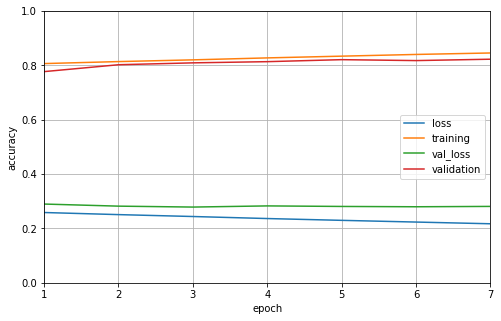

In [31]:
acc = pd.DataFrame({'epoch': [ i + 1 for i in history.epoch ],
                    'training': history.history['acc'],
                    'validation': history.history['val_acc'],
                    'loss': history.history['loss'],
                   'val_loss': history.history['val_loss']})
ax = acc.ix[:,:].plot(x='epoch', figsize={5,8}, grid=True)
ax.set_ylabel("accuracy")
ax.set_ylim([0.0,1.0]);

## Print best validation accuracy and epoch

In [9]:
max_val_acc, idx = max((val, idx) for (idx, val) in enumerate(history.history['val_binary_accuracy']))
print('Maximum accuracy at epoch', '{:d}'.format(idx+1), '=', '{:.4f}'.format(max_val_acc))

Maximum accuracy at epoch 10 = 0.8369


## Evaluate the model with best validation accuracy on the test partition

In [38]:
model.load_weights(MODEL_WEIGHTS_FILE)

results = model.predict([Q1_test,Q2_test],batch_size=4096, verbose=1)
submission = pd.DataFrame(results,columns=['is_duplicate'])
submission.to_csv('submission_quora_lstm.csv',index_label='test_id')

2345796/2345796 [==============================] - 165s   
